# HDR Plot on the El Niño dataset

## Introduction

In this document, we present how to create a HDR plot to visualize a set of curves. We consider the *El Niño* dataset of 54 curves which represents the temperature of the sea depending on the time from January to December. We show how to reduce the dimension of the space, visualize the curves in the reduced space and identify the outlier curves. 

## Algorithm

We algorithm is based on four main steps: 
* Dimension reduction: we project the curve sample onto the Karhunen-Loève basis, so that each curve is represented by a low dimension vector,
* Distribution fitting: we estimate the distribution of the curves in the reduced space with, e.g., a kernel smoothing estimator,
* Compute high density regions: we compute the minimum volume level sets of given volumes $\alpha$ in the reduced space and identify outlier points,
* Project back in the physical space: we visualize the outlier curves depending on time.

In order to keep the analysis simple, using 2 components for the Karhunen-Loève is a good starting point. This may, however, not be sufficient to correctly represent the information of the curve sample. 

## Description

The *El Niño* dataset consists of 60 years worth of averaged monthly sea surface temperature (SST) in degrees Celcius of the Pacific Ocean at 0-10 deg South and 90-80 deg West between 1950 and 2007.
Years 1982-83 and 1997-98 are outliers; these are the years where *El Niño* (a climate pattern characterized by warming up of the sea surface and higher air pressures) occurred with unusual intensity.

## Source

* NOAA - ERSSTv5 - Nino 1+2 at http://www.cpc.ncep.noaa.gov/data/indices/

In [1]:
import os
import openturns as ot
import othdrplot as othdr
import openturns.viewer as otv

The minimum volume level set computation requires a sampling which can be costly with the default value of the parameters, due to a huge sampling size. Hence, we reduce it to 500.

In [2]:
n_samples = 500
ot.ResourceMap.SetAsBool("Distribution-MinimumVolumeLevelSetBySampling", True)
ot.ResourceMap.Set("Distribution-MinimumVolumeLevelSetSamplingSize", str(n_samples))

Load the dataset.

In [3]:
filename = os.path.join(othdr.__path__[0], "data/npfda-elnino.dat")
separatorstr = " "
data = ot.Sample.ImportFromTextFile(filename, separatorstr)

In order to perform the HDR, we need to create a `ProcessSample` from the dataset file. 

We must create the mesh which corresponds to the time discretization. Before doing this, we must see how the data file is structured in terms of numbers of dates and fields: each row represents a curve, where each column correspond to a specific time. Each column correspond to a specific month in the year:
* column #0: January,
* column #1: February,
* ...
* column #11: December.

In [4]:
print("Number of dates : %d" % (data.getDimension()))
print("Number of fields : %d" % (data.getSize()))

Number of dates : 12
Number of fields : 54


The mesh can then be created from the `IntervalMesher` class, which creates a regular discretization of the interval. 

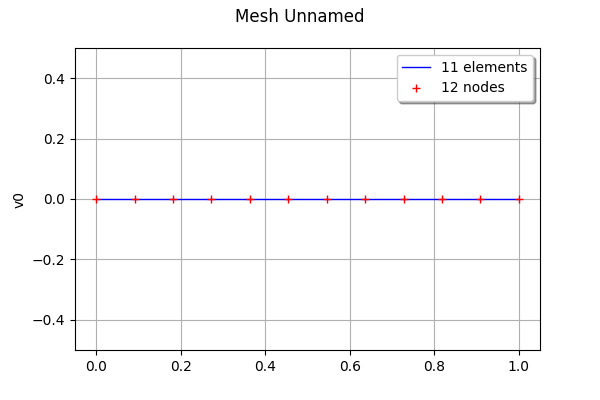

In [5]:
n_nodes = data.getDimension()
mesher = ot.IntervalMesher([n_nodes - 1])
interval = ot.Interval([0.0], [1.0])
mesh = mesher.build(interval)
mesh.draw()

Create the `ProcessSample` from the data:

In [6]:
n_fields = data.getSize()
d_fields = 1
processSample = ot.ProcessSample(mesh, n_fields, d_fields)
for i in range(n_fields):
    trajectory = ot.Sample([[x] for x in data[i, :]])
    processSample[i] = ot.Field(mesh, trajectory)

Before creating the HDR plot, we must reduce the dimension. The `KarhunenLoeveDimensionReductionAlgorithm` simplifies the task by allowing to set the number of required components. In the following, we use 2 components, mainly because it allows to simplify the visualization (2 components may, however, not be sufficient to correctly represent the information in the curve sample). The `getReducedComponents` returns the coordinates of the sample of curves in the reduced space. 

Then the `KernelSmoothing` class is used to approximate the distribution of points in the reduced space. 

In [7]:
# KL decomposition
reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(processSample, 2)
reduction.run()
reducedComponents = reduction.getReducedComponents()

# Distribution fit in reduced space
ks = ot.KernelSmoothing()
reducedDistribution = ks.build(reducedComponents)

We can create a grid with pair plots and marginals.

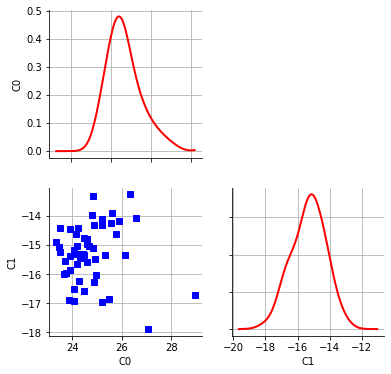

In [8]:
grid = ot.VisualTest.DrawPairsMarginals(reducedComponents, reducedDistribution)
view = otv.View(grid).getFigure().set_size_inches(6.0, 6.0)

The `HighDensityRegionAlgorithm` class plots the high density regions. We configure the $\alpha$ levels so that we see the regions (i.e. the level sets) containing 50% and 80% of the distribution. The outliers, outside the 80% level set, are represented as red points. The inliers, inside the 80% level set, are presented as green points.

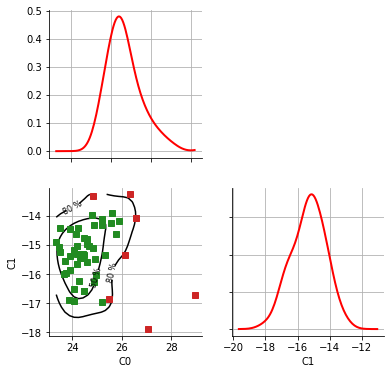

In [9]:
mydp = othdr.HighDensityRegionAlgorithm(
    reducedComponents, reducedDistribution, [0.8, 0.5]
)
mydp.run()
grid = mydp.draw(drawInliers=True)
view = otv.View(grid).getFigure().set_size_inches(6.0, 6.0)

The `ProcessHighDensityRegionAlgorithm` visualizes the curves depending on the time. It uses the process sample, the reduced components, the distribution in the reduced space and the set of $\alpha$ levels.

The graphics must be analyzed depending on several elements.
* By default, the central curve is the curve in the sample which has highest density in the reduced space.
* The confidence band is computed from curves which are inliers in the reduced space. Then, at each time value, the minimum and maximum of these inlier curves is computed. This creates two lower and upper curves, which are filled with color and represent the approximate "confidence band".
* The outlier curves are presented in red.

In [10]:
hdr = othdr.ProcessHighDensityRegionAlgorithm(processSample, reducedComponents, reducedDistribution, [0.8, 0.5])
hdr.run()

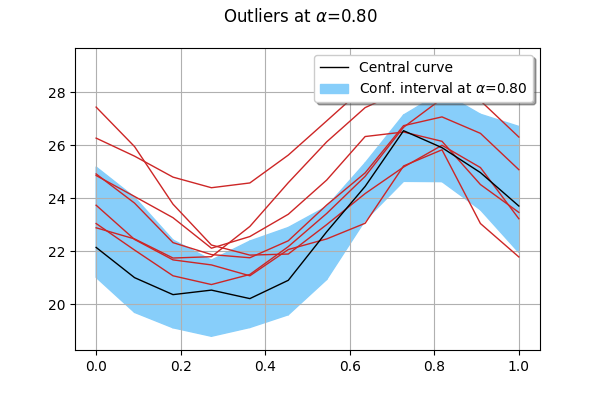

In [11]:
hdr.draw()

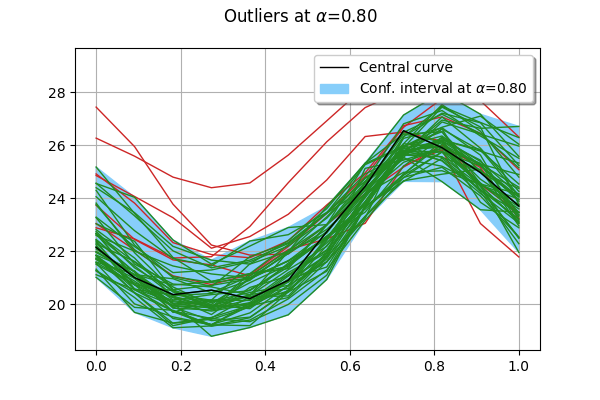

In [12]:
hdr.draw(drawInliers=True)

The `computeIndices` method computes the indices of the outlier curves. 

In [13]:
outlierIndices = hdr.computeIndices()
print("Number of outliers trajectories :", len(outlierIndices))
outlierIndices

Number of outliers trajectories : 7


[3, 7, 22, 32, 33, 41, 47]

In [14]:
inlierIndices = hdr.computeIndices(False)
print("Number of inliers trajectories :", len(inlierIndices))
inlierIndices[:10]

Number of inliers trajectories : 47


[0, 1, 2, 4, 5, 6, 8, 9, 10, 11]

## The central curve

There are at least to ways to define the central curve.
* By default, the central curve is the curve in the sample which has highest density in the reduced space.
* Another way is to compute the sample mean of the curves. 

The `draw` method has a `discreteMean` argument which allows to set this.

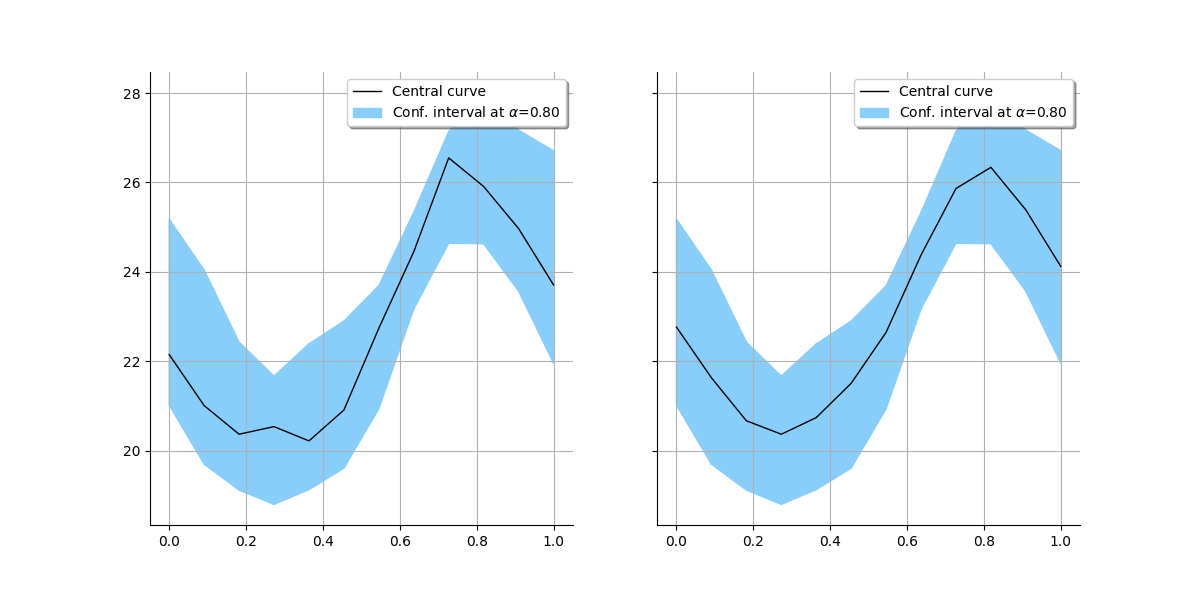

In [15]:
hdr = othdr.ProcessHighDensityRegionAlgorithm(processSample, reducedComponents, reducedDistribution, [0.8, 0.5])
hdr.run()
grid = ot.GridLayout(1, 2)
# 1. With discreteMean to False
graph = hdr.draw(discreteMean=False, drawOutliers=False)
graph.setTitle("Central : highest density curve")
grid.setGraph(0, 0, graph)
# 2. With discreteMean to True
graph = hdr.draw(discreteMean=True, drawOutliers=False)
graph.setTitle("Central : sample mean")
grid.setGraph(0, 1, graph)
grid

The advantage of the left picture is that the central curve is an observation in the sample. Its estimation is only marginaly influenced by one or more outliers in the sample. 

The advantage of the right picture is that the central curve is somewhat smoother. It is a better estimate of the mean of the process if the sample has no outlier. 

Another way would be to compute the mean in the reduced space, but the current implementation does not allows this. Indeed, the sample mean in the reduced space might be a poor estimator if outliers are in the sample. 

The `getMode` method returns the index of the curve with highest density. 

In [16]:
hdr.getMode()

10